<a href="https://colab.research.google.com/github/antonior92/advtrain-linreg/blob/main/notebooks/fig4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%%
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
import tqdm
import matplotlib
import cvxpy as cp


def compute_q(p):
    if p != np.Inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.Inf
    else:
        q = 1
    return q

class AdversarialTraining:
    def __init__(self, X, y, p):
        m, n = X.shape
        q = compute_q(p)
        # Formulate problem
        param = cp.Variable(n)
        param_norm = cp.pnorm(param, p=q)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False

    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, **kwargs)
            v = self.param.value
        except:
            v = np.zeros(self.param.shape)
        return v

#%%
# Path lengh
eps_lasso = 1e-5
eps_ridge = 1e-6
eps_adv = 1e-5
# alpha_max
amax_ridge = 1e4
amax_adv = 10
# number of points along the path
n_alphas = 40
# alpha_min path (automatically computed)
amin_ridge = eps_ridge * amax_ridge
amin_adv = eps_adv * amax_adv

# Generate Gaussian dataset
parameter_norm = 1
noise_std = 0.1
n_features = 200
n_samples = 60
seed = 1


#%%
rng = np.random.RandomState(seed)
beta = 1 / np.sqrt(n_features) * np.ones(n_features)
X = rng.randn(n_samples, n_features)

# Generate output with random additive noise
e = rng.randn(n_samples)
y = X @ beta + noise_std * e

#%%
ridge = lambda X, y, a: linear_model.Ridge(alpha=a, fit_intercept=False).fit(X, y).coef_
advtrain_l2 = lambda X, y, a: AdversarialTraining(X, y, p=2)(adv_radius=a)
advtrain_linf = lambda X, y, a: AdversarialTraining(X, y, p=np.inf)(adv_radius=a)

def compute_coefs_path(estimator, amin, amax, n_alphas):
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs_.append(estimator(X, y, a))
    return alphas, np.stack((coefs_)).T

# ridge
alphas_ridge, coefs_ridge = compute_coefs_path(ridge, amin_ridge, amax_ridge, n_alphas)
# lasso
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, n_alphas=n_alphas, eps=eps_lasso)
coefs_lasso = np.concatenate([np.zeros([X.shape[1], 1]), coefs_lasso], axis=1)
alphas_lasso = np.concatenate([1e2 * np.ones([1]), alphas_lasso], axis=0)
# adv train l2
alpha_advtrain_l2 , coefs_advtrain_l2  = compute_coefs_path(advtrain_l2, amin_adv, amax_adv, n_alphas)
# adv train linf
alpha_advtrain_linf , coefs_advtrain_linf  = compute_coefs_path(advtrain_linf, amin_adv, amax_adv, n_alphas)

 85%|████████▌ | 34/40 [00:21<00:07,  1.31s/it]/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


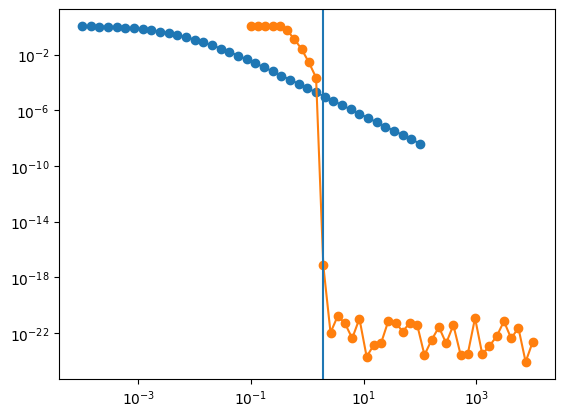

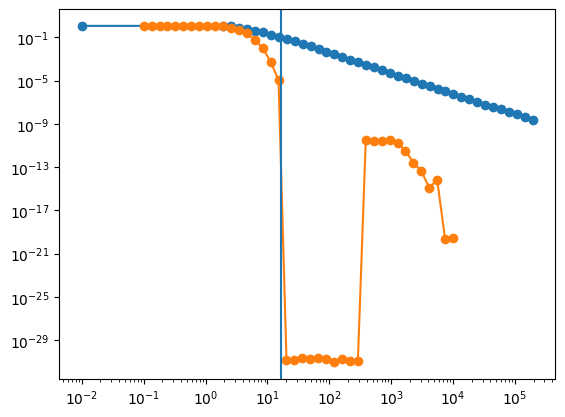

In [11]:
def get_max_alpha(X, y, p=2):
    n, m = X.shape
    var = cp.Variable(n)

    obj = cp.Maximize(var @ y)
    constr = [cp.pnorm(X.T @ var, p) <= 1,]
    prob = cp.Problem(obj, constr)
    result = prob.solve()
    return 1 / (n * np.max(np.abs(var.value)))


#%% Plot MSE
def plot_mse(alphas, coefs, name, ax):
    mse = np.mean((y[:, None] - X @ coefs) **2, axis=0)
    ax.plot(1/alphas, mse, 'o-')
    if name in 'advtrain_l2':
      ax.axvline(1 / get_max_alpha(X, y, p=2))

    if name in 'advtrain_linf':
      ax.axvline(1 / get_max_alpha(X, y, p=np.Inf))
    ax.set_xscale('log')
    ax.set_yscale('log')


fig, ax = plt.subplots(num='l2')
plot_mse(alphas_ridge, coefs_ridge, 'ridge', ax)
plot_mse(alpha_advtrain_l2, coefs_advtrain_l2, 'advtrain_l2', ax)

fig, ax = plt.subplots(num='linf')
plot_mse(alphas_lasso, coefs_lasso, 'lasso', ax)
plot_mse(alpha_advtrain_linf, coefs_advtrain_linf, 'advtrain_linf', ax)
plt.show()

*For simplicity, we run the experiment only once. Thus, we don't include the error bars. You can see the full experiment in the git repository.*